In [1]:
import numpy as np
from typing import Union, Iterable, Sized, Tuple
import torch
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
import math
import os
import random
import logging
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
import plotly.graph_objects as go

from data_processing.data_loader import *
#from data_processing.data_loader_new import *

from model.activation_layers import ExULayer, ReLULayer, LipschitzMonotonicLayer
from model.model_network import HierarchNeuralAdditiveModel
from utils.model_architecture_type import get_defult_architecture_phase1, get_defult_architecture_phase2
from training.trainer import Trainer
from training.trainer_learn_concepts import Trainer_concepts
from utils.utils import define_device, plot_concepts_weights, plot_data_histograms, plot_pred_data_histograms, seed_everything
from utils.model_parser import parse_args
from utils.visualize_shape_functions import get_shape_functions, get_shape_functions_synthetic_data
import wandb



In [2]:
# Parsing arguments
args = parse_args()

# Set device and seed
device = define_device("auto")
print(device)

seed_everything(args.seed)

# args.hierarch_net = 1
# args.batch_size = 64
# args.num_exp = 5000

cuda


DATA PROCESSING

In [3]:
# DATA PROCESSING: Generate synthetic data for Phase 1 and Phase 2
from utils.utils import plot_data_histograms

args.num_exp = 10
args.in_features = 5
args.latent_dim = 3
args.output_dim = 4

X, y_phase1, shape_functions_phase1, out_weights = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_exp=args.num_exp, raw_features=args.in_features, num_concepts=args.latent_dim, is_test=False, seed=args.seed)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, num_classes=args.output_dim, is_test=False)

# # Generate synthetic data for validation set
# X_val, y_phase1_val, _, _ = SyntheticDatasetGenerator.get_synthetic_data_phase1(2000, args.in_features)
# y_phase2_val, _ = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1_val)

if args.hierarch_net:
    train_loader = SyntheticDatasetGenerator.make_loader(X, y_phase2, batch_size=args.batch_size)
    #val_loader = SyntheticDatasetGenerator.make_loader(X_val, y_phase2_val, batch_size=args.batch_size)
else:
    train_loader = SyntheticDatasetGenerator.make_loader(X, y_phase1, batch_size=args.batch_size)
    #val_loader = SyntheticDatasetGenerator.make_loader(X_val, y_phase1_val, batch_size=args.batch_size)


# Print the size of training and validation datasets
print("Train size:", len(train_loader.dataset))
#print("Val size:", len(val_loader.dataset))

# input_fig = plot_data_histograms(values=X, values_name='Input', save_path="data_processing/plots/")
# input_fig.show()

# concept_fig = plot_data_histograms(values=y_phase1, values_name='Concept',nbins=80, save_path="data_processing/plots/")
# concept_fig.show()

# target_fig = plot_data_histograms(values=y_phase2, values_name='Target',nbins=100, save_path="data_processing/plots/")
# target_fig.show()

torch.Size([10, 5])
torch.Size([10, 3])
torch.Size([10, 4])
output_0 = 0.50 * concept[:, 0] + 0.30 * exp(0.2 * concept[:, 1]) + 0.20 * (concept[:, 2] ** 2)
output_1 = 0.35 * exp(0.2 * concept[:, 0]) + 0.22 * (concept[:, 1] ** 2) + 0.60 * concept[:, 2]
output_2 = 0.24 * (concept[:, 0] ** 2) + 0.70 * concept[:, 1] + 0.40 * exp(0.2 * concept[:, 2])
output_3 = 0.80 * concept[:, 0] + 0.45 * exp(0.2 * concept[:, 1]) + 0.26 * (concept[:, 2] ** 2)
Train size: 10


# Train the model

In [4]:
args.featureNN_arch_phase1 = "single_to_multi_output"
args.featureNN_arch_phase2 = "parallel_single_output"
args.learn_only_concepts = 0
args.hierarch_net = 1

Initialaize Model 

In [5]:
# Model definition: HierarchNeuralAdditiveModel
model = HierarchNeuralAdditiveModel(num_inputs=args.in_features,
                                        task_type= args.task_type,
                                        hierarch_net= args.hierarch_net,
                                        learn_only_concepts = args.learn_only_concepts,
                                        #phase1 - latent_features:
                                        num_units_phase1= args.first_hidden_dim_phase1,
                                        hidden_units_phase1 = args.hidden_dim_phase1,
                                        hidden_dropout_phase1 =args.hidden_dropout_phase1,
                                        feature_dropout_phase1 = args.feature_dropout_phase1,
                                        shallow_phase1 = args.shallow_phase1,
                                        first_layer_phase1 = args.first_activate_layer_phase1,
                                        hidden_layer_phase1= args.hidden_activate_layer_phase1,         
                                        latent_var_dim= args.latent_dim,
                                        featureNN_architecture_phase1= args.featureNN_arch_phase1,
                                        weight_norms_kind_phase1= args.weight_norms_kind_phase1, 
                                        group_size_phase1= args.group_size_phase1, 
                                        monotonic_constraint_phase1= args.monotonic_constraint_phase1,
                                        #phase2 - final outputs:
                                        num_units_phase2= args.first_hidden_dim_phase2,
                                        hidden_units_phase2 = args.hidden_dim_phase2,
                                        hidden_dropout_phase2 = args.hidden_dropout_phase2,
                                        feature_dropout_phase2 = args.feature_dropout_phase1,
                                        shallow_phase2 = args.shallow_phase2,
                                        first_layer_phase2 = args.first_activate_layer_phase2,
                                        hidden_layer_phase2 = args.hidden_activate_layer_phase2,          
                                        output_dim = args.output_dim,
                                        featureNN_architecture_phase2 = args.featureNN_arch_phase2,
                                        weight_norms_kind_phase2 = args.weight_norms_kind_phase2, 
                                        group_size_phase2 = args.group_size_phase2, 
                                        monotonic_constraint_phase2 = args.monotonic_constraint_phase2
                                        ).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

if 1:
    layers_name = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            layers_name.append(name)
            print(f'{name}: {param.numel()} parameters')
if 0:
    print(summary(model,input_size=(1, 10)))

Number of parameters: 634008
NAM_features.bias: 3 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.0.weight: 64 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.0.bias: 1 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.1.weight: 4096 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.1.bias: 64 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.2.weight: 2048 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.2.bias: 64 parameters
NAM_features.feature_nns.0.feature_nns.output_layer.weight: 32 parameters
NAM_features.feature_nns.0.feature_nns.output_layer.bias: 1 parameters
NAM_features.feature_nns.0.multi_output_layer.weight: 3 parameters
NAM_features.feature_nns.1.feature_nns.hidden_layers.0.weight: 64 parameters
NAM_features.feature_nns.1.feature_nns.hidden_layers.0.bias: 1 parameters
NAM_features.feature_nns.1.feature_nns.hidden_layers.1.weight: 4096 parameters
NAM_features.feature_nns.1.feature_nns

Train the model

In [6]:
# Initialize the Trainer class
from training.trainer_utils import get_param_groups, set_lr_scheduler_params, visualize_loss

print("Training Hierarchical NAM...")
print(f"Phase1 architecture: [{args.first_activate_layer_phase1}: {args.first_hidden_dim_phase1}, {args.hidden_activate_layer_phase1}: {args.hidden_dim_phase1}]")
if args.hierarch_net:
        print(f"Phase2 architecture: [{args.first_activate_layer_phase2}: {args.first_hidden_dim_phase2}, {args.hidden_activate_layer_phase2}: {args.hidden_dim_phase2}]")

args.lr_scheduler = 'CosineAnnealingLR'

scheduler_params = set_lr_scheduler_params(args, args.lr_scheduler)
print(scheduler_params)

# Initialize W&B run and log the parameters
wandb.init(project='Hirarchial_GAMs-synt_data', config=args)

# Initialize the Trainer class
trainer = Trainer_concepts(
        model=model,
        optimizer=args.optimizer,
        loss_function=None,
        lr_scheduler=args.lr_scheduler, 
        scheduler_params=scheduler_params,
        eval_metric=None, 
        epochs=20, 
        batch_size=args.batch_size, 
        learning_rate=args.learning_rate, 
        weight_decay=args.weight_decay, 
        l1_lambda_phase1=args.l1_lambda_phase1,
        l1_lambda_phase2=args.l1_lambda_phase2,
        l2_lambda_phase1=args.l2_lambda_phase1,
        l2_lambda_phase2=args.l2_lambda_phase2,
        monotonicity_lambda_phase1=args.monotonicity_lambda_phase1,
        monotonicity_lambda_phase2=args.monotonicity_lambda_phase2,
        eval_every=args.eval_every,
        early_stop_delta=args.early_stop_delta,
        early_stop_patience=args.early_stop_patience,
        clip_value=args.clip_value,
        device_name="auto"
        )


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Training Hierarchical NAM...
Phase1 architecture: [ReLU: 64, ReLU: [64, 32]]
{'T_max': 1000, 'eta_min': 0, 'last_epoch': -1}


wandb: Currently logged in as: yuvalzehavi22 (yuvalzehavi_22). Use `wandb login --relogin` to force relogin


In [7]:
# Run the training phase
all_param_groups=None
train_loss_history, val_loss_history = trainer.train(train_loader, all_param_groups)

  0%|          | 0/20 [00:00<?, ?it/s]

latent_features
 torch.Size([20, 3])
logits:
 torch.Size([20, 4])
y:
 torch.Size([20, 4])
tensor([ -3.0335,   1.0534, -11.9679,  -4.7952,  -0.0853,   1.1695,  -1.9700,
         -0.3024,  -3.3906,  -1.8647,  -8.3991,  -5.2871,  -2.8050,  -1.1275,
         -7.7238,  -4.6707,  -6.5473,  -4.8526, -16.0153,  -9.6462,  -1.7326,
         -0.2769,  -2.4975,  -2.7224,  -6.8015,  -5.2864, -15.3019, -10.1186,
         -3.4528,  -0.7235,  -5.0775,  -5.1216,  -6.0807,  -3.3584, -11.8197,
         -8.8425,  -2.3712,   0.1415,  -6.4691,  -3.7152,  -1.7080,   2.3799,
         -5.3953,  -2.6794,  -3.0975,  -1.8671,  -5.7352,  -4.6836,  -2.5652,
         -1.9136,  -5.4620,  -3.9763,  -1.7759,  -0.7120,  -3.6031,  -2.5646,
         -4.1838,  -1.8111,  -6.6076,  -6.3684,  -3.3384,  -0.3871,  -5.5855,
         -4.8905,  -2.4109,  -3.2887,  -6.0185,  -3.8237,  -2.6889,  -1.4508,
        -10.6189,  -4.5920,  -4.9398,  -2.8321,  -7.6776,  -7.2784,  -5.4153,
         -5.8477, -16.5490,  -8.1336], device='cuda:

 25%|██▌       | 5/20 [00:00<00:01,  8.26it/s]

Epoch 0 | Train Loss: 34.28911 | Train MAE: 4.69344 | Train RMSE: 5.85569
latent_features
 torch.Size([20, 3])
logits:
 torch.Size([20, 4])
y:
 torch.Size([20, 4])
tensor([-6.9839e+00, -4.9707e+00, -1.5252e+01, -1.0351e+01, -1.6878e+00,
        -3.4113e+00, -3.0155e+00, -2.5702e+00, -1.1641e+00, -5.8226e-01,
        -1.6526e-01, -1.7847e+00, -3.2715e+00, -3.9616e+00, -9.7285e+00,
        -5.4489e+00, -2.6414e+00, -1.8521e+00, -6.4543e+00, -4.1420e+00,
        -2.1805e+00, -3.1156e+00, -4.4725e+00, -3.5501e+00, -2.1011e+00,
        -2.7599e+00, -2.2348e+00, -3.2820e+00, -2.1821e+00, -2.7526e+00,
        -3.7740e+00, -3.5047e+00, -3.3099e+00, -1.9610e+00, -7.7624e+00,
        -5.1631e+00, -1.4991e+00, -3.7597e-01, -2.5883e+00, -2.3579e+00,
        -3.2695e+00, -3.2177e+00, -4.1779e+00, -4.8777e+00, -3.9147e+00,
        -1.1379e-02, -6.2700e+00, -5.6356e+00, -6.9354e+00, -4.9734e+00,
        -9.0854e+00, -1.0148e+01, -1.2112e+00, -2.7214e+00, -3.0120e+00,
        -2.3180e+00, -2.0836e+00,

 55%|█████▌    | 11/20 [00:00<00:00, 15.88it/s]

latent_features
 torch.Size([20, 3])
logits:
 torch.Size([20, 4])
y:
 torch.Size([20, 4])
tensor([ -2.7887,   1.6291,  -2.2541,  -4.5825,  -6.5773,  -3.1741, -11.5919,
         -9.9247,  -5.8170,  -5.7949,  -9.1208,  -8.5758,  -4.0725,   0.1172,
         -0.7013,  -6.2707,  -2.9436,  -1.5149,  -1.9719,  -4.9735,  -2.1672,
         -0.3728,  -5.6692,  -4.0657,  -0.9766,  -0.6814,  -2.0449,  -2.0751,
         -0.2233,   1.8203,   0.3714,  -0.8576,  -5.2832,  -2.1440, -11.8387,
         -8.1734,  -1.4910,  -0.3478,   1.4183,  -2.4371,  -1.9692,   0.8885,
         -1.4353,  -3.0365,  -3.5029,  -6.3223, -13.4845,  -5.8637,  -2.5564,
          3.4228,   0.2566,  -4.0360,  -2.3149,  -2.7947,  -6.0503,  -4.0812,
         -0.2247,   0.6130,   1.3027,  -0.7479,  -3.6804,  -1.0894,  -1.8756,
         -5.3240,  -1.8405,   3.8704,   2.3355,  -3.1009,  -0.2611,   1.4949,
          2.2538,  -0.8428,  -1.0967,   0.8941,  -0.6620,  -2.5544,  -3.3389,
         -1.1354,  -4.7386,  -5.4508], device='cuda:

 85%|████████▌ | 17/20 [00:01<00:00, 20.69it/s]

latent_features
 torch.Size([20, 3])
logits:
 torch.Size([20, 4])
y:
 torch.Size([20, 4])
tensor([ -0.3577,   0.5996,   2.4487,  -1.3016,   2.4259,   3.4988,  -0.0198,
          2.4037,  -6.4249,  13.0759,  -5.1777,  -9.7338,   1.2302,  -3.0530,
         -0.8950,   0.3374,  -1.8086,   8.4857,  -2.1325,  -3.5859,  -0.2313,
          2.8507,  -8.4336,  -1.7039,  -0.3891,  -1.4939,   1.2637,  -1.0288,
         -0.8738,   0.9687, -10.6345,  -2.3637,   2.9670,   0.6813,   1.8011,
          2.3503,  -1.8403,   5.9144,   1.2375,  -2.9374,  -2.5739,   2.1048,
         -0.7351,  -4.2057,   1.7906,  -2.8244,  -3.0007,   1.2962,  -1.0297,
          4.6151,   5.4371,  -2.0592,   5.5750,  -1.1371,  -0.6810,   6.5619,
         -2.8641,  -2.6398,  -4.7719,  -4.9268,   9.4692,   4.0250,  -1.3504,
         11.1519,   1.7339,  -1.5213,   1.0155,   1.4027,   5.5289,  11.5784,
          7.4541,   6.2697,  -2.1962,   5.9032,  -0.2780,  -3.8550,   6.6019,
         -3.5206,   2.6040,   7.8062], device='cuda:

100%|██████████| 20/20 [00:01<00:00, 15.40it/s]

latent_features
 torch.Size([20, 3])
logits:
 torch.Size([20, 4])
y:
 torch.Size([20, 4])
tensor([-1.3474e+00, -2.3773e+00,  6.3123e-01, -2.3998e+00, -2.9058e-01,
         8.3088e-01,  2.3001e+00, -9.3512e-01, -5.1665e+00, -5.8772e+00,
        -1.0712e+01, -8.3090e+00, -2.4710e+00, -1.1352e+00, -5.0049e+00,
        -3.8960e+00, -1.8378e+00,  1.3066e+00, -2.2119e+00, -2.9506e+00,
         1.1980e+00, -6.3965e+00, -7.4817e+00,  5.6709e-01, -3.2138e-01,
        -2.5546e+00,  4.3601e-01, -1.3199e+00, -3.4577e+00, -6.0307e+00,
        -1.1365e+01, -6.0467e+00, -3.5453e+00,  3.2969e-01, -3.5199e+00,
        -5.8084e+00, -6.2646e+00, -3.7765e+00, -9.0866e+00, -9.8341e+00,
        -4.2323e+00,  2.8046e+00, -1.3223e+00, -6.5385e+00,  7.3505e-01,
        -1.1829e+00,  1.5133e+00,  7.1012e-02, -1.7434e+00, -1.6256e+00,
        -1.6184e+00, -3.0169e+00, -1.3304e+00,  7.3050e-01, -1.8328e+00,
        -2.3878e+00, -9.1687e-01, -2.1952e+00, -6.2792e+00, -2.4546e+00,
        -3.3499e-01,  1.4645e-01, 

In [6]:
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=0.001,
                                 weight_decay=0.0001,
                                )
grad_norms = {}

for epoch in tqdm(range(2)):
    model.train()

    # Training loop
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        print(X.shape)
        optimizer.zero_grad()

        # Forward pass
        logits, latent_features, phase1_gams_out,_ = model(X)

        loss = torch.nn.functional.mse_loss(logits.view(-1), y.view(-1))
        print(loss)

        # Backward pass
        loss.backward()

        optimizer.step()

#         # Check if gradients are computed
#         grad_norms[epoch] = {}
#         for name, param in model.named_parameters():
#             if param.requires_grad and param.grad is not None: #and name in layers_to_track 
#                grad_norms[epoch][name] = param.grad.norm().item()
               
# print(grad_norms)

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([10, 5])
torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
tensor(48.2513, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

torch.Size([10, 5])
torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
tensor(47.9023, device='cuda:0', grad_fn=<MseLossBackward0>)


In [10]:
x_trail = torch.tensor([
    [2.0, 3.0, 4.0],  # Sample 1
    [1.0, 0.5, 2.5],  # Sample 2
], dtype=torch.float32)

x_trail.shape

torch.Size([2, 3])

In [ ]:
class mymodel(torch.nn.Module):
    def __init__(self,
                 num_inputs: int,
                 num_units_phase1: int= 64,
                 hidden_units_phase1: list = [64, 32],
                 hidden_dropout_phase1: float = 0.,
                 feature_dropout_phase1: float = 0.,
                 shallow_phase1: bool = True,
                 first_layer_phase1: str = 'ReLU',
                 hidden_layer_phase1: str = 'ReLU',         
                 latent_var_dim: int = 1,
                 featureNN_architecture_phase1: str = 'multi_output',
                 output_dim: int = 1,
                 ):
        super().__init__()



        self.input_size = num_inputs
        self.latent_var_dim = latent_var_dim
        self.num_classes = output_dim
        
        # phase1 hyperparameters - latent_features:
        self.num_units_phase1 = num_units_phase1
        self.hidden_units_phase1 = hidden_units_phase1
        self.hidden_dropout_phase1 = hidden_dropout_phase1
        self.feature_dropout_phase1 = feature_dropout_phase1
        self.shallow_phase1 = shallow_phase1
        self.activation_first_layer_phase1 = first_layer_phase1
        self.activation_hidden_layer_phase1 = hidden_layer_phase1
        self.architecture_type_phase1 = featureNN_architecture_phase1

        self.NAM_features = NeuralAdditiveModel(
                        num_inputs = self.input_size,
                        num_units = self.num_units_phase1,
                        hidden_units = self.hidden_units_phase1,
                        hidden_dropout = self.hidden_dropout_phase1,
                        feature_dropout = self.feature_dropout_phase1,
                        shallow = self.shallow_phase1,
                        first_layer = self.activation_first_layer_phase1,
                        hidden_layer = self.activation_hidden_layer_phase1,
                        num_classes = self.latent_var_dim,
                        architecture_type = self.architecture_type_phase1,     
                        )


    def forward(self, x):
        latent_outputs, phase1_gams_out = self.NAM_features(x)
        outputs = self.phase2(latent_outputs)  # Phase 2 computation using latent features
        phase2_gams_out = None
        return outputs, latent_outputs, phase1_gams_out, phase2_gams_out

        
    def phase2(self, concepts):
        # Incorporate get_synthetic_data_phase2_ logic here
        outputs = []
        for j in range(self.num_classes):
            output_sum = torch.zeros(concepts.size(0), device=concepts.device)

            class_weights = [0.5 + 0.1 * j, 0.3 + 0.05 * j, 0.2 + 0.02 * j, 0.1 + 0.03 * j]

            for i in range(concepts.size(1)):
                if (j + i) % 3 == 0:
                    output_sum += class_weights[0] * concepts[:, i]  # Linear
                elif (j + i) % 3 == 1:
                    output_sum += class_weights[1] * torch.exp(0.2 * concepts[:, i])  # Exponential
                elif (j + i) % 3 == 2:
                    output_sum += class_weights[2] * (concepts[:, i] ** 2)  # Quadratic
                else:
                    output_sum += class_weights[3] * (concepts[:, i]**3)  # Cubic

            outputs.append(output_sum.reshape(-1, 1))

        y = torch.cat(outputs, dim=1)
        return y

# LOAD MODEL

In [33]:
args.num_exp = 10000 
args.epochs = 200 
args.featureNN_arch_phase1 = 'single_to_multi_output' 
args.featureNN_arch_phase2 = 'multi_output' 
args.first_hidden_dim_phase1 = 64 
args.hidden_dim_phase1 = [64, 32] 
args.first_activate_layer_phase1 = "ReLU" 
args.hidden_activate_layer_phase1 = "ReLU" 
args.first_hidden_dim_phase2 = 64 
args.hidden_dim_phase2 = [32] 
args.first_activate_layer_phase2 = "ReLU" 
args.hidden_activate_layer_phase2 = "ReLU" 
#--batch_size 128 --monotonicity_lambda_phase2 0.001 --lr_scheduler 'CosineAnnealingLR' --learning_rate 0.003

# Model definition: HierarchNeuralAdditiveModel
model = HierarchNeuralAdditiveModel(num_inputs=args.in_features,
                                        task_type= args.task_type,
                                        hierarch_net= args.hierarch_net,
                                        #phase1 - latent_features:
                                        num_units_phase1= args.first_hidden_dim_phase1,
                                        hidden_units_phase1 = args.hidden_dim_phase1,
                                        hidden_dropout_phase1 =args.hidden_dropout_phase1,
                                        feature_dropout_phase1 = args.feature_dropout_phase1,
                                        shallow_phase1 = args.shallow_phase1,
                                        first_layer_phase1 = args.first_activate_layer_phase1,
                                        hidden_layer_phase1= args.hidden_activate_layer_phase1,         
                                        latent_var_dim= args.latent_dim,
                                        featureNN_architecture_phase1= args.featureNN_arch_phase1,
                                        weight_norms_kind_phase1= args.weight_norms_kind_phase1, 
                                        group_size_phase1= args.group_size_phase1, 
                                        monotonic_constraint_phase1= args.monotonic_constraint_phase1,
                                        #phase2 - final outputs:
                                        num_units_phase2= args.first_hidden_dim_phase2,
                                        hidden_units_phase2 = args.hidden_dim_phase2,
                                        hidden_dropout_phase2 = args.hidden_dropout_phase2,
                                        feature_dropout_phase2 = args.feature_dropout_phase1,
                                        shallow_phase2 = args.shallow_phase2,
                                        first_layer_phase2 = args.first_activate_layer_phase2,
                                        hidden_layer_phase2 = args.hidden_activate_layer_phase2,          
                                        output_dim = args.output_dim,
                                        featureNN_architecture_phase2 = args.featureNN_arch_phase2,
                                        weight_norms_kind_phase2 = args.weight_norms_kind_phase2, 
                                        group_size_phase2 = args.group_size_phase2, 
                                        monotonic_constraint_phase2 = args.monotonic_constraint_phase2
                                        ).to(device)

model.load_state_dict(torch.load('/home/yuvalzehavi1/Repos/multi-classification-NAM/best_model.pt'))
model.to(device)

model.eval()
X = X.to(device)
logits, latent_features, _, _ = model(X)

#plot_concepts_weights(out_weights, model, model_predict = True)

<ipython-input-33-063ce4f80d67>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/yuvalzehavi1/Repos/multi-classification-NAM/best_mo

In [18]:
logits

tensor([[10.0199,  5.0720],
        [ 9.1329,  4.3980],
        [ 5.2326,  2.8340],
        ...,
        [ 6.9861,  3.8871],
        [ 6.8559,  3.6117],
        [ 5.7123,  2.9578]], device='cuda:0', grad_fn=<AddBackward0>)

In [74]:
num_test_exp=500
X_new, y_phase1, shape_functions_phase1, out_weights = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
_, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(latent_features, is_test=True)

x_values_phase1 = torch.linspace(0, 3, num_test_exp).reshape(-1, 1).to(device)
x_values_phase2 = torch.linspace(round(float(y_phase1.min())), round(float(y_phase1.max())), num_test_exp).reshape(-1, 1).to(device)


torch.Size([500, 10])
torch.Size([500, 4])
torch.Size([500, 2])


In [81]:
y_phase1.shape
latent_features[:, 0].shape

torch.Size([500])

In [66]:
X_new.cpu().detach().numpy()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00601202, 0.00601202, 0.00601202, ..., 0.00601202, 0.00601202,
        0.00601202],
       [0.01202405, 0.01202405, 0.01202405, ..., 0.01202405, 0.01202405,
        0.01202405],
       ...,
       [2.9879758 , 2.9879758 , 2.9879758 , ..., 2.9879758 , 2.9879758 ,
        2.9879758 ],
       [2.993988  , 2.993988  , 2.993988  , ..., 2.993988  , 2.993988  ,
        2.993988  ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ]], dtype=float32)

In [45]:
X_new = X_new.to(device)
logits, latent_features, phase1_gams_out, phase2_gams_out= model(X_new)


In [77]:
shape_functions_phase2['f_0_0'].shape

torch.Size([500])

In [78]:
phase2_gams_out.shape

torch.Size([500, 2, 4])

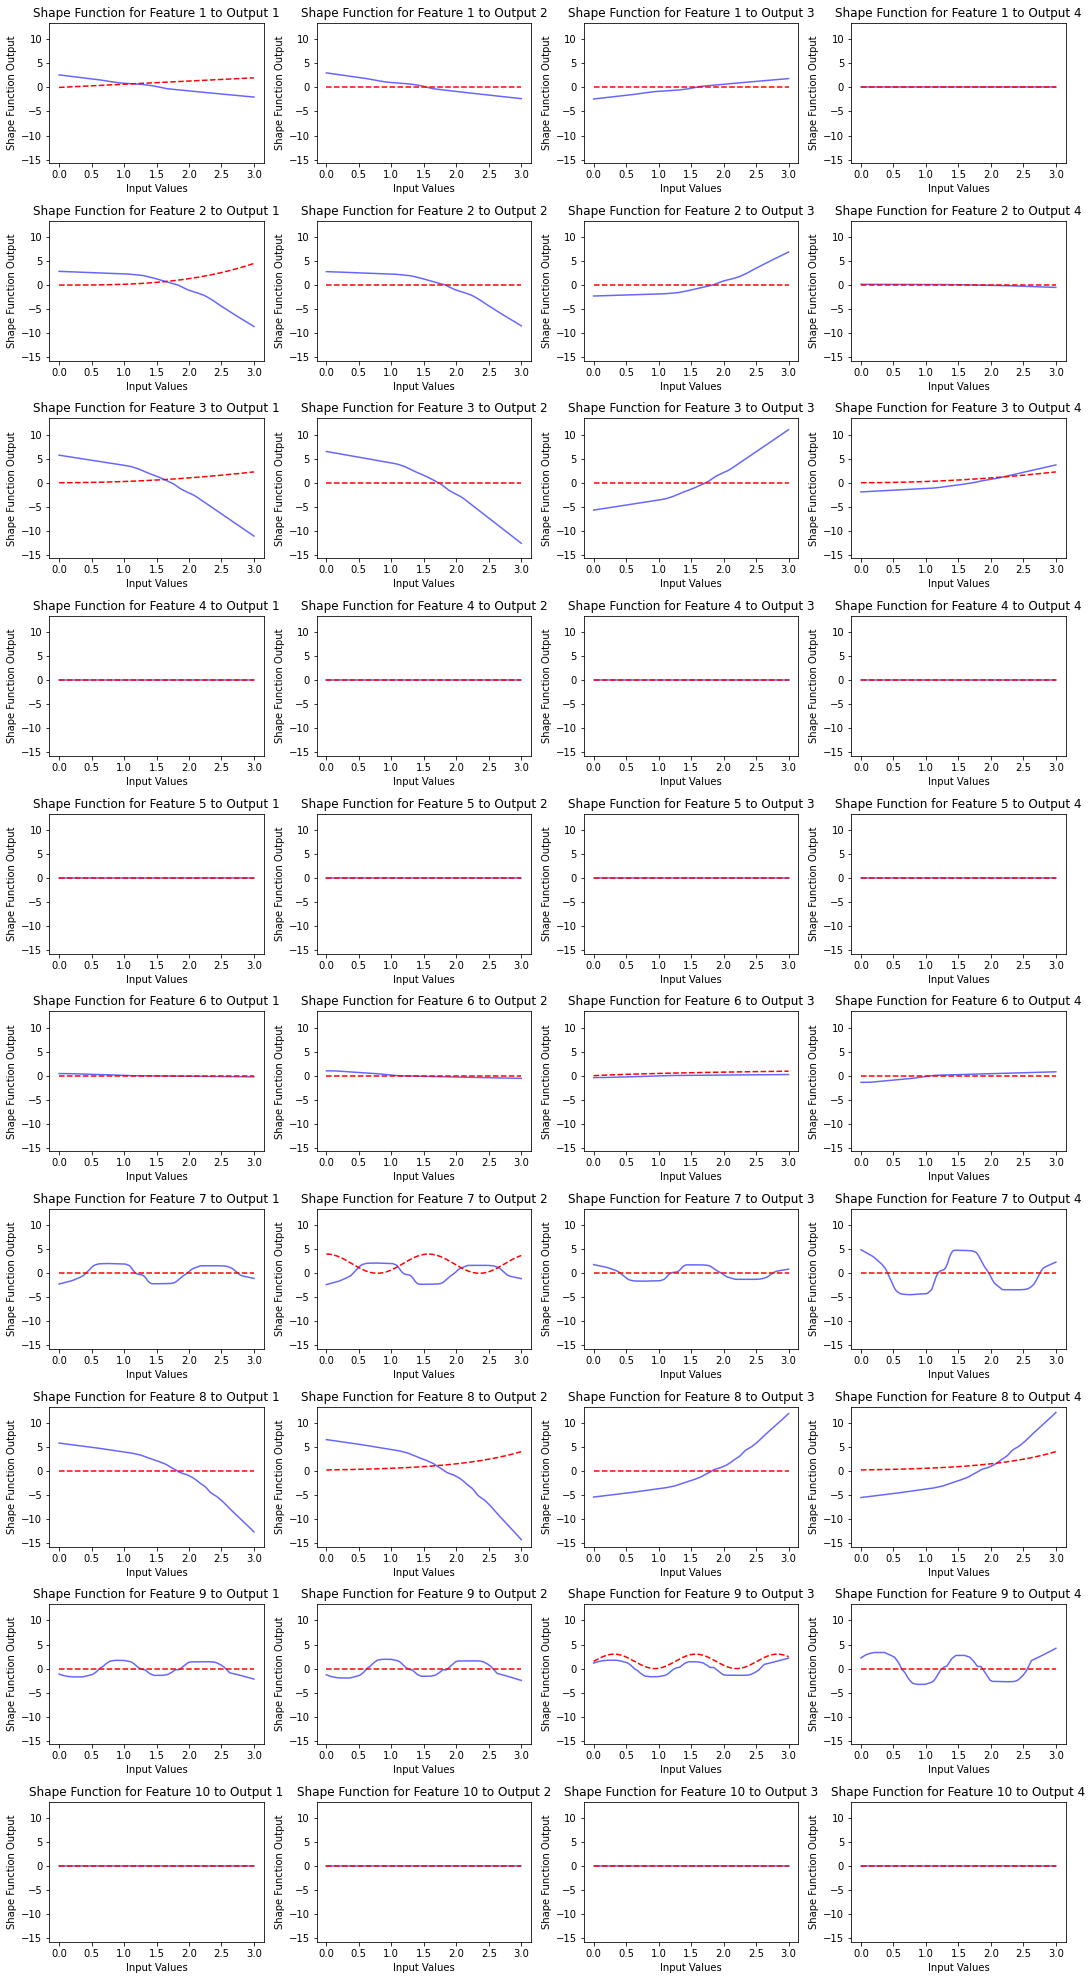

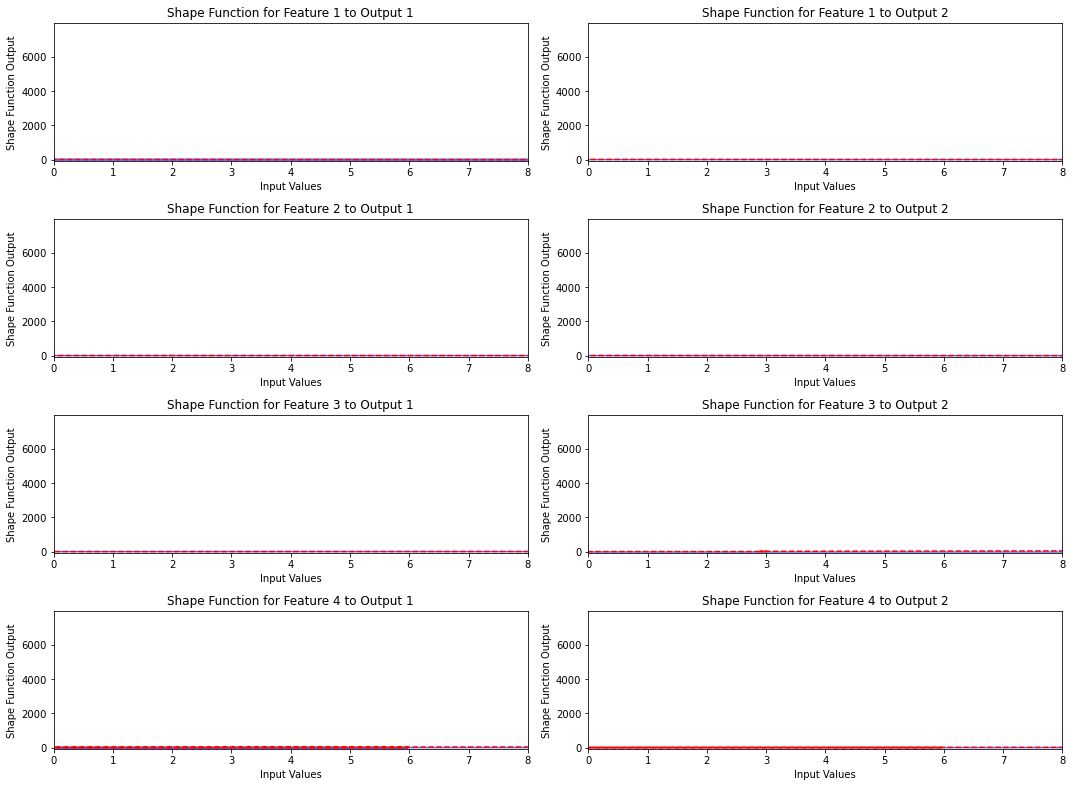

In [82]:
def plot_shape_functions(phase_gams_out, X, shape_functions, num_features=10, num_outputs=4, phase_2=False):
    """
    Plots the learned shape functions for each feature.
    
    Parameters:
    - phase1_gams_out (torch.Tensor): The shape functions output tensor of shape [samples, outputs, features]
    - X (torch.Tensor): The input feature values, used for the x-axis
    - shape_functions (dict): Dictionary containing the true shape functions for each feature-output pair
    - num_features (int): Number of features
    - num_outputs (int): Number of outputs per feature (from phase1_gams_out)
    """
    # Ensure `X` is on the CPU and converted to NumPy for plotting
    X = X.cpu().detach().numpy()
    
    # Move phase1_gams_out to CPU for visualization
    phase_gams_out = phase_gams_out.detach().cpu().numpy()

    # Determine global min and max values for consistent y-axis limits across all plots
    global_min = min(phase_gams_out.min(), *[min(func) for func in shape_functions.values()])
    global_max = max(phase_gams_out.max(), *[max(func) for func in shape_functions.values()])

    # Apply a 10% padding for better visualization
    y_min = global_min - 0.1 * abs(global_min)
    y_max = global_max + 0.1 * abs(global_max)


    # Create a figure with a subplot for each feature
    fig, axes = plt.subplots(num_features, num_outputs, figsize=(15, num_features * 3))

    for feature_idx in range(num_features):
        for output_idx in range(num_outputs):
            # Select the subplot for this feature and output
            ax = axes[feature_idx, output_idx] if num_features > 1 else axes[output_idx]

                    # Get the learned shape function values for this feature and output
            learned_shape_func = phase_gams_out[:, output_idx, feature_idx]

            # Retrieve the true shape function for the current feature-output pair
            true_shape_func = shape_functions[f'f_{output_idx}_{feature_idx}']

            # Plot the learned shape function for the current feature and output
            ax.plot(X[:, feature_idx], learned_shape_func, color='blue', alpha=0.6)

            # Plot the true shape function
            ax.plot(X[:, feature_idx], true_shape_func, color='red', linestyle='--')

            # Set consistent y-limits across all subplots
            if not phase_2:
                ax.set_ylim([y_min, y_max])

            if phase_2:
                ax.set_xlim([0, 8])

            # Set a title and labels
            ax.set_title(f'Shape Function for Feature {feature_idx + 1} to Output {output_idx + 1}')
            ax.set_xlabel("Input Values")
            ax.set_ylabel("Shape Function Output")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Example usage
# Assuming `X` is the input tensor used to generate phase1_gams_out
# Make sure `X` has the same number of samples as phase1_gams_out
plot_shape_functions(phase1_gams_out, X_new, shape_functions_phase1, num_features=10, num_outputs=4, phase_2=False)
plot_shape_functions(phase2_gams_out, latent_features, shape_functions_phase2, num_features=4, num_outputs=2, phase_2=True)

In [27]:
with torch.no_grad():
    feature_output = model.NAM_output.feature_nns[0](x_values_phase1[:, 0])[:, 0].cpu().numpy()
    
feature_output

array([-0.96968144, -0.9688754 , -0.9680694 , -0.96726334, -0.9664573 ,
       -0.9656513 , -0.9648453 , -0.96403915, -0.9632331 , -0.9624271 ,
       -0.96162105, -0.960815  , -0.96000904, -0.959203  , -0.95839685,
       -0.9575909 , -0.95678484, -0.9559789 , -0.95517266, -0.9543666 ,
       -0.95356065, -0.9527545 , -0.9519486 , -0.95114255, -0.95033646,
       -0.9495306 , -0.9487245 , -0.9479184 , -0.94711244, -0.94630635,
       -0.94550025, -0.9446943 , -0.9438881 , -0.9430822 , -0.9422761 ,
       -0.94147015, -0.9406642 , -0.939858  , -0.93905187, -0.9382459 ,
       -0.9374398 , -0.93663377, -0.93582773, -0.9350217 , -0.93421566,
       -0.93340963, -0.93260366, -0.9317976 , -0.9309916 , -0.93018556,
       -0.92937934, -0.9285735 , -0.9277674 , -0.9269613 , -0.92615527,
       -0.92534924, -0.9245432 , -0.9237372 , -0.9229311 , -0.92182386,
       -0.92069507, -0.91956615, -0.91843736, -0.91730875, -0.9161799 ,
       -0.9150511 , -0.91392225, -0.91279364, -0.91166484, -0.91

In [16]:
def visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions, vis_lat_features=False):
    
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)

    # Initialize global min and max for setting the y-limits
    global_min = float('inf')
    global_max = float('-inf')

    # First pass: Determine the global min and max across all predicted and true shape functions
    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                # Predicted shape function
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()

                # Get true shape function
                true_feature_output = shape_functions[f'f_{j}_{i}']

                # Update global min and max
                global_min = min(global_min, feature_output.min(), true_feature_output.min())
                global_max = max(global_max, feature_output.max(), true_feature_output.max())

    # Second pass: Plot the predicted and true shape functions with consistent y-limits
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15, 30))

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()

                # Get the true shape function for this feature-output pair
                true_feature_output = shape_functions[f'f_{j}_{i}']

                # Plot the predicted shape function
                ax1 = axes[i, j]
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Predicted Feature {i}', color='blue', alpha=0.6)
                
                # Plot the true shape function
                ax1.plot(x_values.cpu().numpy(), true_feature_output, label=f'True Feature {i}', color='red', linestyle='--')

                # Set labels and title
                ax1.set_title(f'Feature {i} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')

                # Set consistent y-limits across all plots
                ax1.set_ylim([global_min * 1.1, global_max * 1.1])  # Adjust the limits slightly for better visualization

                # Add legend
                ax1.legend()

    plt.tight_layout()
    plt.show()
    plt.close()
    
    return

torch.Size([500, 10])
torch.Size([500, 4])
torch.Size([500, 2])


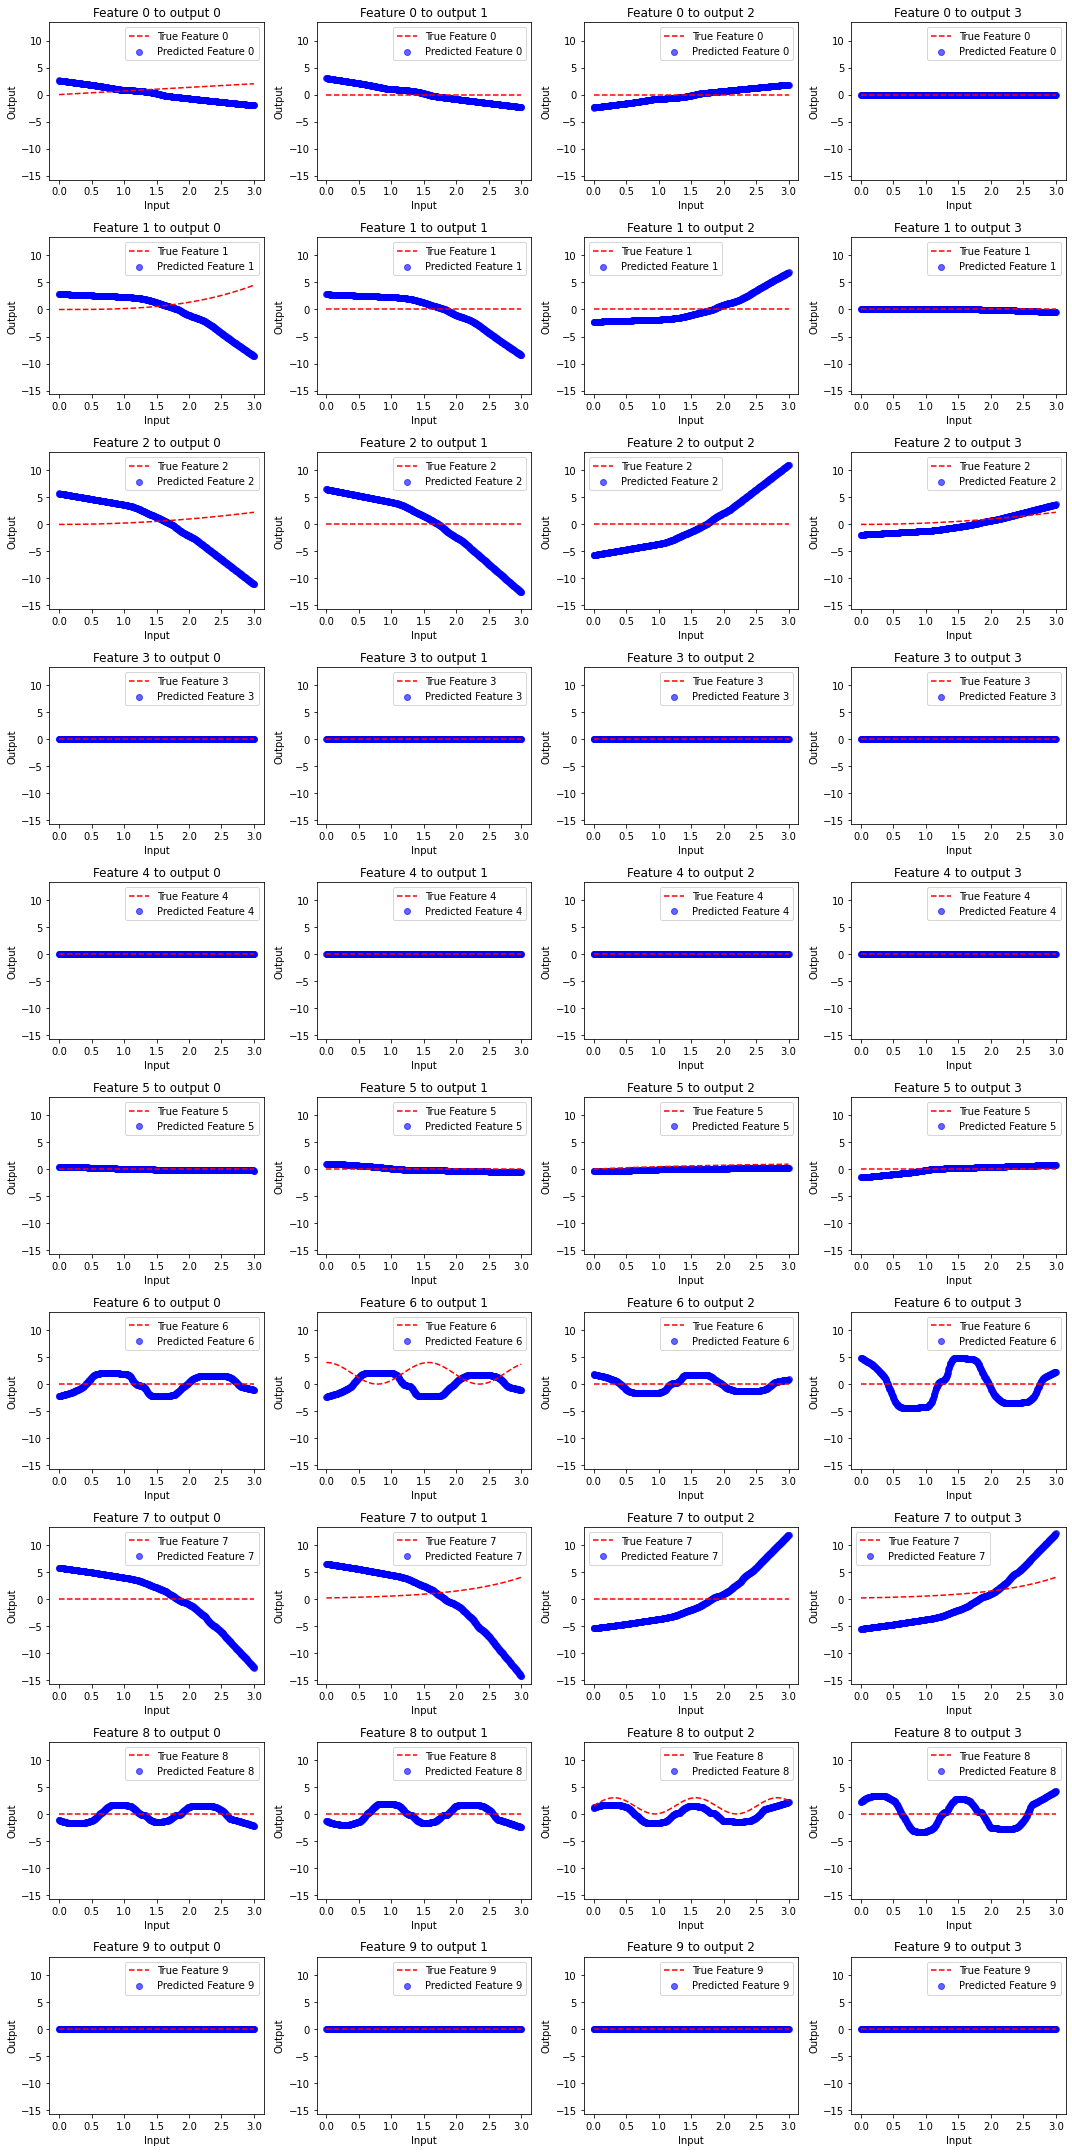

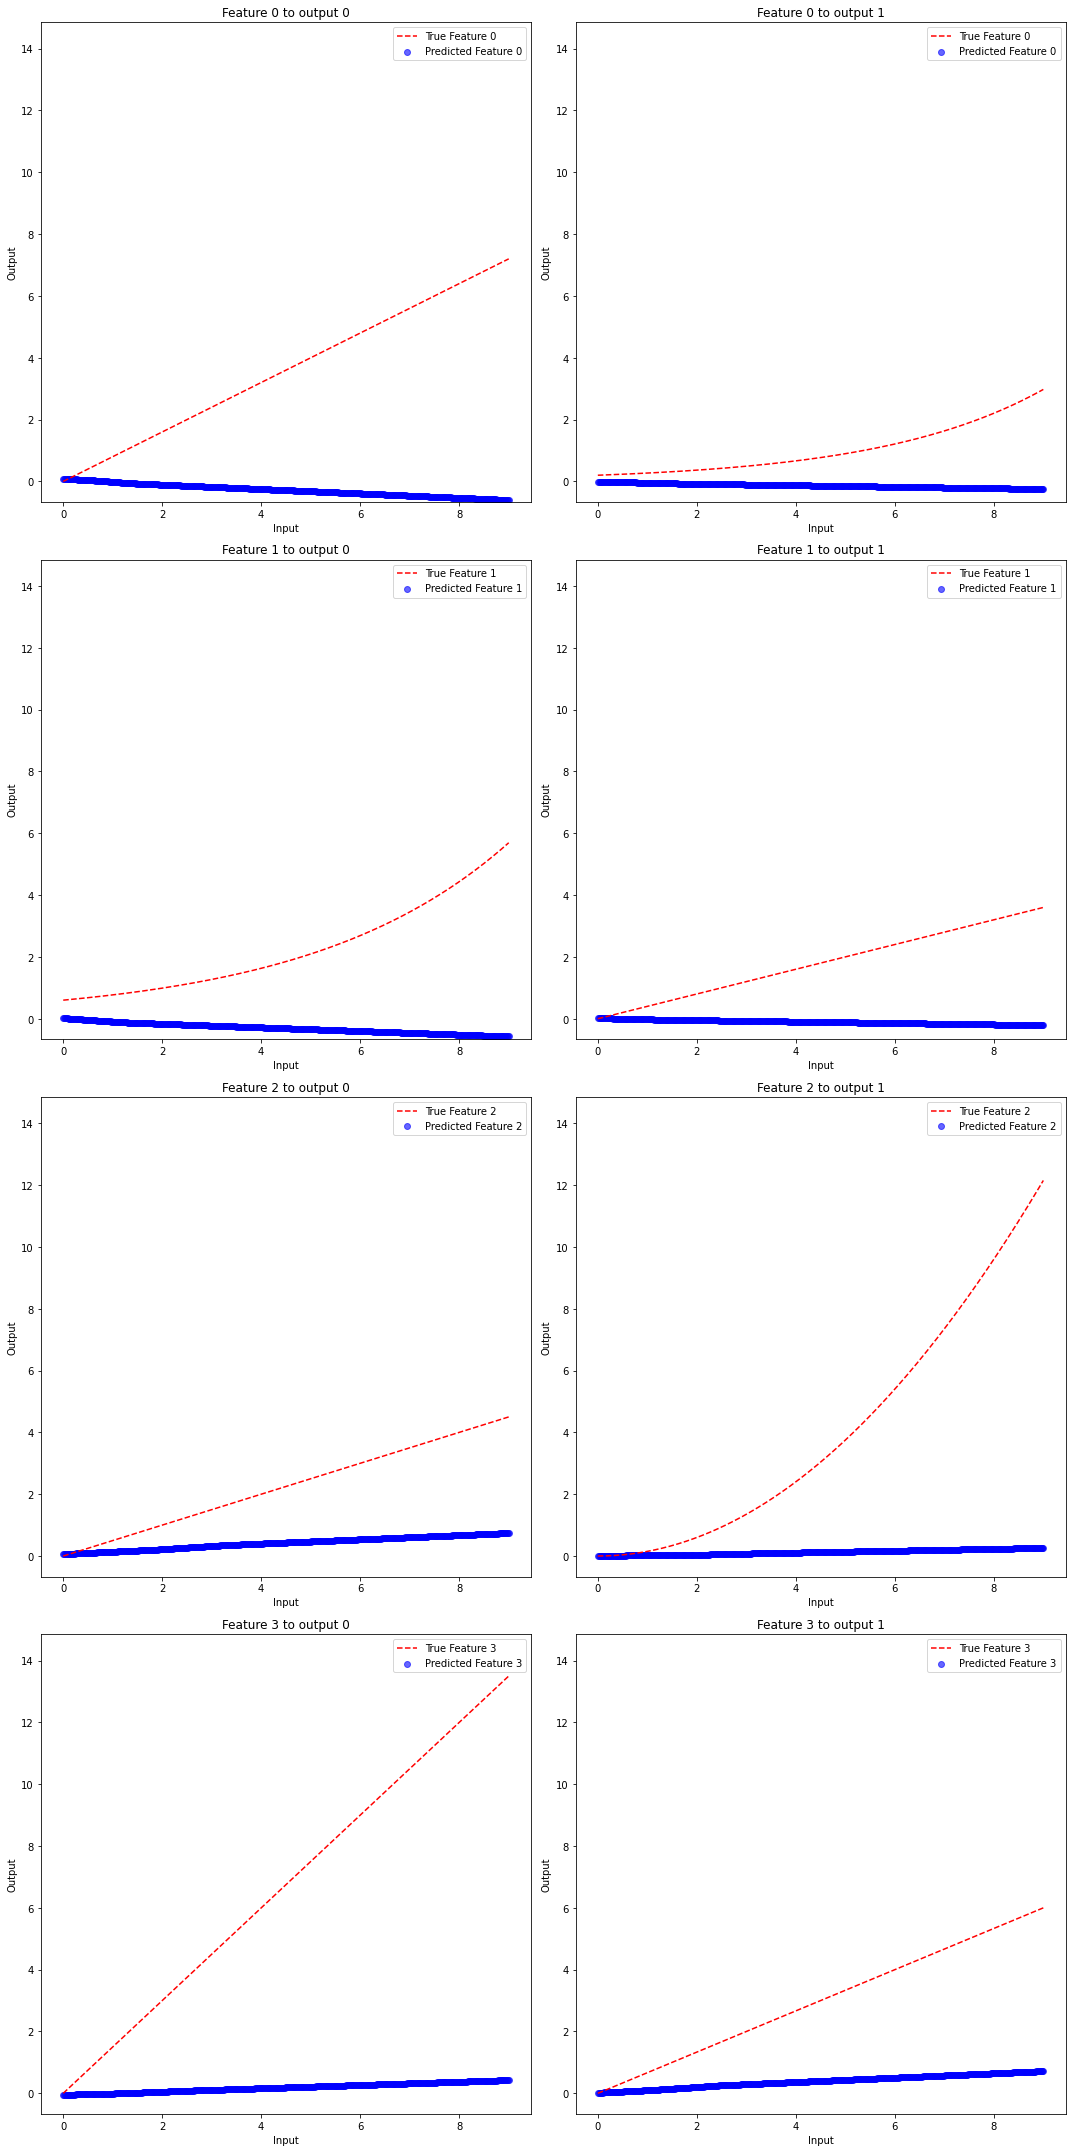

In [17]:
input_dim_phase1 = args.in_features
output_dim_phase1 = args.latent_dim
visualize_combined_gam(model, x_values_phase1, input_dim_phase1, output_dim_phase1, shape_functions_phase1, vis_lat_features=True)

input_dim_phase2 = args.latent_dim
output_dim_phase2 = args.output_dim
visualize_combined_gam(model, x_values_phase2, input_dim_phase2, output_dim_phase2, shape_functions_phase2)

In [ ]:
def get_model_outputs_for_shape_functions(model, X):
    """
    Extracts shape functions from each phase, ensuring clear interpretation
    of both phase outputs and latent features (if applicable).
    """
    if model.hierarch_net:
        logits, latent_features, phase1_gams_out, phase2_gams_out = model(X)
    else:
        logits, phase1_gams_out = model(X)
        latent_features, phase2_gams_out = None, None
    
    return phase1_gams_out, phase2_gams_out, latent_features

def visualize_shape_functions(model, X, shape_functions, is_hierarchical, phase_name="Phase"):
    """
    Visualizes the shape functions learned by the model in comparison with the true shape functions.
    """
    # Extract outputs for visualization
    phase1_gams_out, phase2_gams_out, latent_features = get_model_outputs_for_shape_functions(model, X)
    
    # Set the outputs and dimensions to visualize based on the phase
    if phase_name == "Phase 1":
        outputs_to_visualize = phase1_gams_out
        input_dim = outputs_to_visualize.shape[1]  # Number of features
        output_dim = outputs_to_visualize.shape[2] if outputs_to_visualize.dim() > 2 else 1  # Number of outputs per feature
        true_shape_funcs = shape_functions['phase1']
    elif phase_name == "Phase 2" and is_hierarchical:
        outputs_to_visualize = phase2_gams_out
        input_dim = outputs_to_visualize.shape[1]
        output_dim = outputs_to_visualize.shape[2] if outputs_to_visualize.dim() > 2 else 1
        true_shape_funcs = shape_functions['phase2']
    else:
        return  # No Phase 2 outputs if the model is non-hierarchical

    # Plot each learned shape function compared to the true shape function
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15, 30))
    global_min, global_max = float('inf'), float('-inf')

    # Determine global min/max for y-limits
    for i in range(input_dim):
        for j in range(output_dim):
            predicted_shape_func = outputs_to_visualize[:, i, j].cpu().numpy() if output_dim > 1 else outputs_to_visualize[:, i].cpu().numpy()
            true_shape_func = true_shape_funcs[f'f_{j}_{i}'] if output_dim > 1 else true_shape_funcs[f'f_{0}_{i}']
            global_min = min(global_min, predicted_shape_func.min(), true_shape_func.min())
            global_max = max(global_max, predicted_shape_func.max(), true_shape_func.max())
    
    # Plot with consistent y-limits
    for i in range(input_dim):
        for j in range(output_dim):
            ax = axes[i, j] if input_dim > 1 else axes[j]  # Handle case of single input dim

            predicted_shape_func = outputs_to_visualize[:, i, j].cpu().numpy() if output_dim > 1 else outputs_to_visualize[:, i].cpu().numpy()
            true_shape_func = true_shape_funcs[f'f_{j}_{i}'] if output_dim > 1 else true_shape_funcs[f'f_{0}_{i}']

            # Plot predicted and true shape functions
            ax.scatter(X.cpu().numpy(), predicted_shape_func, label='Predicted', color='blue', alpha=0.6)
            ax.plot(X.cpu().numpy(), true_shape_func, label='True', color='red', linestyle='--')

            # Set y-limits
            ax.set_ylim([global_min * 1.1, global_max * 1.1])
            ax.set_title(f'{phase_name} Shape Function: Feature {i} to Output {j}')
            ax.set_xlabel('Input')
            ax.set_ylabel('Output')
            ax.legend()

    plt.tight_layout()
    plt.show()

# Example of how to use these functions with synthetic data
def visualize_learned_shape_functions(model, synthetic_data_gen, args, num_samples=1000):
    # Generate synthetic data
    X, y_phase1, shape_functions_phase1, out_weights = synthetic_data_gen.get_synthetic_data_phase1(num_samples, args.in_features, is_test=True)
    X = X.to(next(model.parameters()).device)  # Ensure X is on the same device as the model

    # Visualize Phase 1 shape functions
    visualize_shape_functions(model, X, {'phase1': shape_functions_phase1}, model.hierarch_net, phase_name="Phase 1")

    # Visualize Phase 2 shape functions if hierarchical
    if model.hierarch_net:
        _, shape_functions_phase2 = synthetic_data_gen.get_synthetic_data_phase2(y_phase1, is_test=True)
        visualize_shape_functions(model, X, {'phase2': shape_functions_phase2}, model.hierarch_net, phase_name="Phase 2")

# Dataset

In [45]:
def get_synthetic_data_phase1(num_exp=10, in_features=10):
    # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
    X_uniform = Uniform(-1, 1).sample((num_exp, in_features-5))
    
    # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
    X_normal = torch.normal(0, 1, (num_exp, 5))
    
    # Combine the uniform and normal features
    X = torch.cat([X_uniform, X_normal], dim=1)
    print(X.shape)
    
    # creating y_1
    y_1 = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * torch.log(100 * X[:, 5].abs()) + torch.sin(5 * X[:, 6])
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # creating y_3
    y_3 = -(3/4) * torch.exp(-4 * X[:, 7].abs()) + torch.cos(5 * X[:, 8])
    y_3 = y_3.reshape(-1, 1)
    
    # creating y_4
    y_4 = torch.sin(5 * X[:, 5]) + 0.5*(3*(X[:, 2]**2)-1)  
    y_4 = y_4.reshape(-1, 1)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2, y_3, y_4], dim=1)
    print(y.shape)
    
    return X, y


def get_synthetic_data_phase2(X_input):
    
    # creating y_1
    y_1 = 4*X_input[:, 0] + 0.5*X_input[:, 1]
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * X_input[:, 2] + 5 * X_input[:, 3]
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2], dim=1)
    print(y.shape)
    
    return y


def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [ ]:
X, y = get_synthetic_data_phase1(num_exp=1, in_features=10)
Y = get_synthetic_data_phase2(y)

# Model architecture

In [47]:
def truncated_normal_(tensor, mean: float = 0., std: float = 1.):
    """
    Initializes a tensor with values from a truncated normal distribution
    """
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

# ActivationLayer Class
class ActivationLayer(torch.nn.Module):
    """
    Abstract base class for layers with weights and biases
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__()
        
        self.weight = torch.nn.Parameter(torch.empty((in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.empty(in_features))

    def forward(self, x):
        raise NotImplementedError("abstract method called")


class ExULayer(ActivationLayer):
    """
    Custom layer using exponential activation with weight and bias initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        truncated_normal_(self.weight, mean=4.0, std=0.5)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x): 
        exu = (x - self.bias) @ torch.exp(self.weight)
        output = torch.clip(exu, 0, 1)
        
        if 0:
            print('ExULayer_weights:', self.weight.detach().cpu().numpy())
            print('ExULayer Normalization L1\n:', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ExULayer Normalization L2\n:',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


class ReLULayer(ActivationLayer):
    """
    Custom layer using ReLU activation with Xavier weight initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        torch.nn.init.xavier_uniform_(self.weight)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x):
        output = F.relu((x - self.bias) @ self.weight)
        
        if 0:
            print('ReLULayer_weights:', self.weight.detach().cpu().numpy())
            print('ReLULayer Normalization L1:\n', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ReLULayer Normalization L2:\n',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


# FeatureNN Class
class FeatureNN(torch.nn.Module):
    """
    Neural network for individual features
    """
    def __init__(self,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 dropout: float = .5,
                 output_dim: int = 1,
                 ):
        super().__init__()
        
        # First (shallow) layer
        self.shallow_layer = shallow_layer(1, shallow_units)
        
        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        in_units = shallow_units
        for out_units in hidden_units:
            self.hidden_layers.append(hidden_layer(in_units, out_units))
            in_units = out_units  # Update in_units to the output of the last layer
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout)
        
        # Output linear layer
        self.output_layer = torch.nn.Linear(in_units, output_dim, bias=False)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Pass through the shallow layer
        x = self.shallow_layer(x)
        #x = self.dropout(x)
        
        # Pass through each hidden layer with dropout
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.dropout(x)
            
        # Final output layer
        x = self.output_layer(x)
        
        return x


# Neural Additive Model (NAM) Class
class NeuralAdditiveModel(torch.nn.Module):
    """
    Combines multiple feature networks, each processing one feature, with dropout and bias
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 hidden_dropout: float = 0.,
                 feature_dropout: float = 0.,
                 output_dim: int = 1,
                 ):
        super().__init__()
        
        self.input_size = input_size

        if isinstance(shallow_units, list):
            assert len(shallow_units) == input_size
        elif isinstance(shallow_units, int):
            shallow_units = [shallow_units for _ in range(input_size)]

        self.feature_nns = torch.nn.ModuleList([
            FeatureNN(shallow_units=shallow_units[i],
                      hidden_units=hidden_units,
                      shallow_layer=shallow_layer,
                      hidden_layer=hidden_layer,
                      dropout=hidden_dropout,
                      output_dim=output_dim)
            for i in range(input_size)
        ])
        self.feature_dropout = torch.nn.Dropout(p=feature_dropout)
        self.bias = torch.nn.Parameter(torch.zeros(output_dim))
        
    def forward(self, x):
        # Collect outputs from each feature network
        FeatureNN_out = self._feature_nns(x)
        
        # Concatenates a sequence of tensors along the latent features dimension 
        f_out = torch.stack(FeatureNN_out, dim=-1)
        
        # Sum across features and add bias
        f_out = self.feature_dropout(f_out)
        outputs = f_out.sum(axis=-1) + self.bias
        
        if 0:
            print('final output', outputs)
            print('f_out', f_out)
        return outputs, f_out

    def _feature_nns(self, x):
        return [self.feature_nns[i](x[:, i]) for i in range(self.input_size)]
    

# Hirarchical Neural Additive Model Class
class HierarchNeuralAdditiveModel(torch.nn.Module):
    """
    Hierarch Neural Additive Model
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 hidden_dropout: float = 0.,
                 feature_dropout: float = 0.,
                 latent_feature_dropout: float = 0.,
                 latent_var_dim: int = 1,
                 output_dim: int = 1,
                 ):
        super().__init__()

        self.NAM_features = NeuralAdditiveModel(input_size=input_size,
                                shallow_units= shallow_units,
                                hidden_units= hidden_units,
                                shallow_layer= shallow_layer,
                                hidden_layer= hidden_layer,
                                hidden_dropout= hidden_dropout,
                                feature_dropout= feature_dropout,
                                output_dim = latent_var_dim,
                                )
       

        self.NAM_output = NeuralAdditiveModel(input_size=latent_var_dim,
                                shallow_units= shallow_units,
                                hidden_units= hidden_units,
                                shallow_layer= shallow_layer,
                                hidden_layer= hidden_layer,
                                hidden_dropout= hidden_dropout,
                                feature_dropout= latent_feature_dropout,
                                output_dim = output_dim,
                                )

    def forward(self, x):
        
        latent_outputs, f_out = self.NAM_features(x)

        outputs, lat_f_out = self.NAM_output(latent_outputs)
       
         # Apply softmax to get class probabilities
#         outputs = torch.softmax(outputs, dim=-1)

        if 0:
            print('x:', x.shape)
            print('latent_outputs:',latent_outputs.shape)
            print('f_out:',f_out.shape)
            print('outputs:',outputs.shape)
            print('lat_f_out:',lat_f_out.shape)  
            
        return outputs, lat_f_out

# Loss

In [48]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    loss = mse_loss+feat_loss
    return loss

def l1_penalty(params, l1_lambda):
    l1_norm =  torch.stack([torch.linalg.norm(p, 1) for p in params], dim=0).sum()
    return l1_lambda*l1_norm

def l2_penalty(params, l1_lambda):
    l2_norm =  torch.stack([torch.linalg.norm(p, 2) for p in params], dim=0).sum()
    return l1_lambda*l2_norm

# Model training

In [49]:
def train(model, loader, criterion, optimizer, config):
    
    # Run training and track with wandb
#    total_batches = len(loader) * config['epochs']
#    batch_ct = 0
    loss_history = []

    for epoch in tqdm(range(config['epochs'])):
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):
            loss = train_batch(X, y, model, optimizer, criterion)
#            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):    
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, fnns_out = model(X)
    loss = criterion(logits, y, fnns_out, feature_penalty=0.0001)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    if 0:
        print('predict outputs shape:',logits.shape)
        print('true outputs shape:',y.shape)
        print('fnns_out shape:',fnns_out.shape)

    return loss

# Define the Experiment

In [50]:
# define experiment
config = dict(
    epochs=2000, #100
    batch_size=1024, #128
    learning_rate=0.0035,
    weight_decay=0.0001,
    num_exp = 5000,
    in_features = 10,
    shallow_units=20, #50
    hidden_units=(64, 64, 32), #(100, 20)
    feature_dropout=0.2,
    latent_feature_dropout=0.2,
    hidden_dropout=0.2,
    latent_dim=4,
    output_dim=2,
    seed=42,
    dataset="Uniform_distribution",
    architecture="multi_output_NAM")

In [52]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])
    Y = get_synthetic_data_phase2(y)

    train_loader = make_loader(X, Y, batch_size=config['batch_size'])

    # Make the model
    model = HierarchNeuralAdditiveModel(input_size= config['in_features'],
                     shallow_units= config['shallow_units'],
                     hidden_units= config['hidden_units'],
                     shallow_layer = ExULayer,
                     hidden_layer = ReLULayer,
                     hidden_dropout = config['hidden_dropout'],
                     feature_dropout = config['feature_dropout'],
                     latent_feature_dropout = config['latent_feature_dropout'],
                     latent_var_dim = config['latent_dim'], 
                     output_dim = config['output_dim'],     
                     ).to(device)
    
#     model = NeuralAdditiveModel(input_size= config['in_features'],
#                      shallow_units= config['shallow_units'],
#                      hidden_units= config['hidden_units'],
#                      shallow_layer = ExULayer,
#                      hidden_layer = ReLULayer,
#                      hidden_dropout = config['hidden_dropout'],
#                      feature_dropout = config['feature_dropout'],
#                      output_dim = config['latent_dim'],           
#                      ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer

# Run

In [ ]:
# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)
model

In [ ]:
# and use them to train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

# Visualaize shape functions

In [40]:
def get_shape_functions(model, args):
    # Generate input values for plotting
    x_values = torch.linspace(0, 3, 1000).reshape(-1, 1)  # 100 points between -1 and 1

    input_dim = args.latent_dim
    output_dim = args.output_dim
    visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False)

    input_dim = args.in_features
    output_dim = args.latent_dim
    visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = True)
    return

def visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)
    
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                feature_output_max[f'output_{j}'].append(max(feature_output)) 
                feature_output_min[f'output_{j}'].append(min(feature_output))

    for i in range(input_dim):
        with torch.no_grad(): 
            for j in range(output_dim):
                ax1 = axes[i, j]
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Feature {i+1}')
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                #ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

    plt.tight_layout()
    plt.show()
    return

In [15]:
def visualize_true_gam(input_dim, output_dim, shape_functions, x_values):
    
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    for i in range(input_dim):
        for j in range(output_dim):
            ax1 = axes[i, j]
            feature_output = shape_functions[f'f_{j}_{i}']
                
            ax1.scatter(x_values, feature_output, label=f'Feature {i+1}')
            ax1.set_title(f'Feature {i+1} to output {j}')
            ax1.set_xlabel('Input')
            ax1.set_ylabel('Output')
            
    plt.tight_layout()
    plt.show()
    return

In [ ]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = True)

In [ ]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_true_gam(input_dim, output_dim, shape_functions_phase2, x_values)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_true_gam(input_dim, output_dim, shape_functions_phase1, x_values)

In [7]:
import matplotlib.pyplot as plt

def visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions, vis_lat_features=False):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)
    
    # Initialize global min and max for setting the y-limits
    global_min = float('inf')
    global_max = float('-inf')

    # First pass: Determine the global min and max across all predicted and true shape functions
    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                # Predicted shape function
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                # Get true shape function
                true_feature_output = shape_functions[f'f_{j}_{i}'].cpu().numpy()
                # Update global min and max
                global_min = min(global_min, feature_output.min(), true_feature_output.min())
                global_max = max(global_max, feature_output.max(), true_feature_output.max())

    # Second pass: Plot the predicted and true shape functions with consistent y-limits
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15, 30))

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()

                # Get the true shape function for this feature-output pair
                true_feature_output = shape_functions[f'f_{j}_{i}']

                # Plot the predicted shape function
                ax1 = axes[i, j]
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Predicted Feature {i}', color='blue', alpha=0.6)
                
                # Plot the true shape function
                ax1.plot(x_values.cpu().numpy(), true_feature_output, label=f'True Feature {i}', color='red', linestyle='--')

                # Set labels and title
                ax1.set_title(f'Feature {i} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')

                # Set consistent y-limits across all plots
                ax1.set_ylim([global_min * 1.3, global_max * 1.3])  # Adjust the limits slightly for better visualization

                # Add legend
                ax1.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

# input_dim = args.latent_dim
# output_dim = args.output_dim
# visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions_phase2)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions_phase1, vis_lat_features=True)


# MONOTONIC CONSTRAIN

In [20]:
import torch

from training.monotonic_constraints import MonotonicityEnforcer

# Generate random input data
input_data = torch.randn(64, 10)  # Random input tensor of shape [64, 10]
# Generate random logits
logits = torch.randn(64, 4)  # Random logits tensor of shape [64, 4]

monotonicity_enforcer = MonotonicityEnforcer(input_data, logits)

sorted_matrices = monotonicity_enforcer.sort_all_matrices()
# monotonicity_enforcer.calculate_monotonicity_penalty(sorted_matrices)

# monotonicity_penalty = monotonicity_enforcer.compute_penalty()
# monotonicity_penalty

vec = sorted_matrices[0][1, :]
vec

tensor([-1.2131e+00, -2.6891e-01,  3.2324e-01,  5.7755e-02, -9.3960e-01,
        -1.6203e+00,  4.9912e-01, -3.0512e-01,  6.5301e-01, -1.5267e+00,
        -9.7211e-01, -9.8661e-02, -1.6712e+00, -1.4220e+00,  2.4925e+00,
        -1.6119e-03,  5.5195e-01, -3.4573e-01, -1.6241e+00,  3.6123e-01,
        -3.8707e-01, -1.3095e-01,  2.7870e+00,  6.2866e-01, -4.5390e-01,
        -4.1113e-01,  8.2259e-01, -1.4391e+00,  3.9087e-02,  1.1160e+00,
        -2.0168e-01,  8.8280e-01, -6.8461e-02,  1.9376e+00,  2.4617e+00,
        -5.4036e-01,  1.1470e+00,  1.0290e+00, -1.1140e+00, -4.5062e-01,
        -1.3149e+00, -2.1849e+00,  6.4661e-01,  5.7727e-01,  6.2753e-02,
         3.5300e-01, -1.6286e+00,  7.2140e-01, -6.8618e-01,  1.4545e+00,
        -1.5895e+00, -9.6095e-01,  4.2097e-01,  1.1563e+00, -6.0364e-01,
        -8.7300e-02, -7.9702e-01,  1.2671e+00,  1.2011e+00,  1.5858e+00,
        -5.8780e-01,  3.5550e-01,  4.1006e-01,  1.5072e-01])

In [ ]:
input = torch.arange(0,5,0.1)
vec = torch.sin(input)

diffs = vec[1:] - vec[:-1]
diffs = torch.diff(vec)

diffs = torch.diff(vec)
sum_mono = 0
for i in range(1,len(diffs)):
    sum_mono += torch.relu(-(diffs[i-1]*diffs[i]))
sum_mono

tensor([ 0.0000,  0.0998,  0.1987,  0.2955,  0.3894,  0.4794,  0.5646,  0.6442,
         0.7174,  0.7833,  0.8415,  0.8912,  0.9320,  0.9636,  0.9854,  0.9975,
         0.9996,  0.9917,  0.9738,  0.9463,  0.9093,  0.8632,  0.8085,  0.7457,
         0.6755,  0.5985,  0.5155,  0.4274,  0.3350,  0.2392,  0.1411,  0.0416,
        -0.0584, -0.1577, -0.2555, -0.3508, -0.4425, -0.5298, -0.6119, -0.6878,
        -0.7568, -0.8183, -0.8716, -0.9162, -0.9516, -0.9775, -0.9937, -0.9999,
        -0.9962, -0.9825])

# Synt data

In [16]:
def get_synthetic_data_phase1_(num_exp=10, raw_features=10, num_concepts=4, is_test=False):
    # Set a seed for reproducibility
    torch.manual_seed(42)

    # Simulate independent variables, x0,...,xn from a Uniform distribution on [0, 3]
    if is_test:
        x_values = torch.linspace(0, 3, num_exp).reshape(-1, 1)
        X = x_values.repeat(1, raw_features)
    else:
        X = Uniform(0, 3).sample((num_exp, raw_features))
    print(X.shape)

    # Initialize dictionaries for shape functions and weights
    shape_functions = {}
    out_weights = {}

    for j in range(num_concepts):
        for i in range(raw_features):
            shape_functions[f"f_{j}_{i}"] = torch.zeros(num_exp)
            out_weights[f"f_{j}_{i}"] = 0

    # Generate weights and shape functions for each concept
    for j in range(num_concepts):
        # Select consistent feature indices for each concept
        selected_features = torch.arange(raw_features)[j::num_concepts]
        
        # Add additional unique indices if needed
        if len(selected_features) < 3:
            existing_indices = set(selected_features.tolist())
            last_item = (selected_features[-1] + num_concepts) % raw_features
            additional_indices = []
            
            for offset in range(3 - len(selected_features)):
                new_item = (last_item + offset * num_concepts) % raw_features
                
                # Ensure `new_item` is unique by finding the next available index
                while int(new_item) in existing_indices:
                    new_item = (new_item + 1) % raw_features  # Increment and wrap around if necessary
                
                if int(new_item) not in existing_indices:
                    additional_indices.append(int(new_item))
                    existing_indices.add(int(new_item))

            selected_features = torch.cat((selected_features, torch.tensor(additional_indices)))

        # print('selected_features:')
        # print(selected_features)

        for i, feature_idx in enumerate(selected_features):
            key = f"f_{j}_{feature_idx}"

            # Assign weights with more conditional cases for variety
            if i % 2 == 0 and j % 2 == 0:
                out_weights[key] = (i + 2) * 0.5 / (j + 1)
            elif i % 2 == 1 and j % 2 == 1:
                out_weights[key] = (int(feature_idx) + 1) * 0.1 * (j + 1)
            elif int(feature_idx) % 2 == 0:
                out_weights[key] = (i + 1) * 0.25 / (j + 2)
            else:
                out_weights[key] = (int(feature_idx) + 3) * 0.15
            
            # Create shape functions dynamically
            if int(feature_idx) == 0:
                shape_functions[key] = out_weights[key] * X[:, feature_idx]  # Linear function
            elif int(feature_idx) == 1:
                shape_functions[key] = out_weights[key] * torch.cos(4 * X[:, feature_idx])
            elif int(feature_idx) == 2:
                shape_functions[key] = out_weights[key] * (X[:, feature_idx]**2)  # Quadratic
            elif int(feature_idx) == 3:
                shape_functions[key] = out_weights[key] * torch.exp(0.2*X[:, feature_idx])  # Exponential
            elif int(feature_idx) == 4:
                shape_functions[key] = X[:, feature_idx] * 0
            elif int(feature_idx) == 5:
                shape_functions[key] = out_weights[key] * (X[:, feature_idx]**3)
            elif int(feature_idx) == 6:
                shape_functions[key] = out_weights[key] * (torch.sin(5 * X[:, feature_idx])+1)
            elif int(feature_idx) == 7 or int(feature_idx) == 8:
                shape_functions[key] = X[:, feature_idx] * 0
            else:
                shape_functions[key] = out_weights[key] * (torch.log(X[:, feature_idx]+1))

        # Sum up shape functions to form a concept
        concept = sum(shape_functions[f"f_{j}_{feature_idx}"] for feature_idx in selected_features)
        concept = concept.reshape(-1, 1)

        # Concatenate the concept to the concepts matrix
        if j == 0:
            concepts = concept
        else:
            concepts = torch.cat((concepts, concept), dim=1)

    print(concepts.shape)

    return X, concepts, shape_functions, out_weights



def get_synthetic_data_phase2_(concepts, num_classes=2, is_test=False):
        """
        Generate synthetic target values for Phase 2 using input features.
        
        Parameters:
        -----------
        concepts : torch.Tensor
            Input for the layer - the concepts for generating synthetic targets.
        
        is_test : bool
            generate data for testing the results.
        
        Returns:
        --------
        y : torch.Tensor
            Generated target values for Phase 2.
        """
        if is_test:
            x_values = torch.linspace(round(float(concepts.min())), round(float(concepts.max())), concepts.size(0)).reshape(-1, 1) 
            concepts = x_values.repeat(1, concepts.size(1))

        # Creating a dict to save all the true shape functions 
        shape_functions = {}

        # Generate y_i for each output class
        outputs = []
        for j in range(num_classes):
            output_sum = torch.zeros(concepts.size(0))

            # Assign unique weights for this class
            class_weights = [0.5 + 0.1 * j, 0.3 + 0.05 * j, 0.2 + 0.02 * j, 0.1 + 0.03 * j]

            for i in range(concepts.size(1)):
                key = f"f_{j}_{i}"

                # Choose different function types for each concept-to-output mapping
                if (j + i) % 3 == 0:
                    shape_functions[key] = class_weights[0] * concepts[:, i]  # Linear
                elif (j + i) % 3 == 1:
                    shape_functions[key] = class_weights[1] * torch.exp(0.2 * concepts[:, i])  # Exponential
                elif (j + i) % 3 == 2:
                    shape_functions[key] = class_weights[2] * (concepts[:, i] ** 2)  # Quadratic
                else:
                    shape_functions[key] = class_weights[3] * (concepts[:, i]**3) #torch.sin(0.5 * concepts[:, i])  # Sinusoidal

                output_sum += shape_functions[key]  # Add the function to the current output sum

            outputs.append(output_sum.reshape(-1, 1))

        # Stack all outputs to form the final target matrix
        y = torch.cat(outputs, dim=1)
        print(y.shape)

        return y, shape_functions



In [26]:
X, y_phase1, shape_functions_phase1, out_weights = get_synthetic_data_phase1_(50000, 5, 3)
y_phase2, shape_functions_phase2 = get_synthetic_data_phase2_(y_phase1, 4)

shape_functions_phase1
# if args.hierarch_net:
#     train_loader = SyntheticDatasetGenerator.make_loader(X, y_phase2, batch_size=args.batch_size)
# else:
#     train_loader = SyntheticDatasetGenerator.make_loader(X, y_phase1, batch_size=args.batch_size)


# Print the size of training and validation datasets
# print("Train size:", len(train_loader.dataset), "Val size:", len(val_loader.dataset))

# input_fig = plot_data_histograms(values=X, values_name='Input', save_path="data_processing/plots/")
# input_fig.show()

# concept_fig = plot_data_histograms(values=y_phase1, values_name='Concept',nbins=80, save_path="data_processing/plots/")
# concept_fig.show()

# target_fig = plot_data_histograms(values=y_phase2, values_name='Target',nbins=100, save_path="data_processing/plots/")
# target_fig.show()

torch.Size([50000, 5])
torch.Size([50000, 3])
torch.Size([50000, 4])


{'f_0_0': tensor([2.6468, 1.8027, 2.8038,  ..., 0.4185, 1.8094, 2.8454]),
 'f_0_1': tensor([-0.0311, -1.9961,  1.3353,  ...,  0.9651,  0.1681, -1.9960]),
 'f_0_2': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'f_0_3': tensor([1.6004, 1.5827, 1.2652,  ..., 1.1369, 1.0761, 1.0127]),
 'f_0_4': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'f_1_0': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'f_1_1': tensor([-0.0093, -0.5988,  0.4006,  ...,  0.2895,  0.0504, -0.5988]),
 'f_1_2': tensor([0.3298, 1.4172, 1.7007,  ..., 0.1000, 0.0605, 0.5356]),
 'f_1_3': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'f_1_4': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'f_2_0': tensor([0.3309, 0.2253, 0.3505,  ..., 0.0523, 0.2262, 0.3557]),
 'f_2_1': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'f_2_2': tensor([0.4398, 1.8896, 2.2676,  ..., 0.1333, 0.0807, 0.7141]),
 'f_2_3': tensor([1.1854, 1.1723, 0.9372,  ..., 0.8421, 0.7971, 0.7501]),
 'f_2_4': tensor([0., 0., 0.,  ..., 0., 0., 0.])}